# GARCH Volatility Modeling
### Analysis of S&P 500 Volatility Dynamics

This notebook demonstrates advanced volatility modeling techniques using GARCH models
applied to S&P 500 data. We progress from basic univariate GARCH to a
multivariate model and rolling forecast. Lastly, we'll compile for risk management applications. 

Key Analyses:

1. Univariate GARCH modeling and diagnostics

2. Dynamic Conditional Correlation (DCC-GARCH) for multi-asset portfolios

3. Rolling Window Forecasts

4. Risk management applications (VaR, portfolio optimization)

------------------------------------------------------------------------------------------------------

In [1]:
## Setup and Data Preparation
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Define the date range for data retrieval
start_date = '2019-10-04'
filter_date = '2020-01-01'
end_date = '2024-12-31'
# Define tickers for multi-asset analysis
tickers = {
        'SPY': 'S&P 500 ETF',
        'TLT': '20+ Year Treasury ETF', 
        'GLD': 'Gold ETF',
        'VXX': 'Volatility S&P 500 Index ETF'
    }

In [4]:
## Function to load market data
def load_market_data(tickers, start_date, end_date):
    """
    Load market data for specified tickers within a date range.
    Returns a DataFrame with adjusted close prices.
    """
    #print(f"Loading market data from {start_date} to {end_date}") <--Not sure I need to print this
    # Load market data
    data = {}
    for ticker, name in tickers.items():
        #print(f"Retrieving data for {name} ({ticker})") <-- Not sure I need to print this
        temp_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data[ticker] = pd.Series(temp_data['Close'][ticker][:], index=temp_data.index)
        #print(f"Loaded {ticker} ({name}): {len(tickers)} observations") <-- Not sure I need to print this
    
    prices_df = pd.DataFrame.from_dict(data, orient='index').T
    returns_df = prices_df.pct_change().dropna() * 100  # Convert to percentage
    sp500_returns = returns_df['SPY']
    return prices_df, returns_df, sp500_returns

# S&P Summary Statistics and Exploratory Data Analysis
### S&P 500 Summary Analysis

In [ ]:
# executing the function to load market data
prices, returns, sp500_returns_ = load_market_data(tickers, start_date, end_date)

In [7]:
#filter out first 60 days - will use in multivariate GARCH model and correlations analysis
prices_df = prices[prices.index >= filter_date]
returns_df = returns[returns.index >= filter_date]
sp500_returns = sp500_returns_[sp500_returns_.index >= filter_date]

In [ ]:
print(f"\nS&P 500 Returns Summary Statistics:")
print(f"Mean: {sp500_returns.mean():.4f}%")
print(f"Std Dev: {sp500_returns.std():.4f}%")
print(f"Skewness: {sp500_returns.skew():.4f}")
print(f"Kurtosis: {sp500_returns.kurtosis():.4f}")
print(f"Min: {sp500_returns.min():.4f}%")
print(f"Max: {sp500_returns.max():.4f}%")



S&P 500 Returns Summary Statistics:
Mean: 0.0628%
Std Dev: 1.3229%
Skewness: -0.5443
Kurtosis: 11.5024
Min: -10.9424%
Max: 9.0603%


In [50]:
"""S&P 500 Summary Analysis"""
"""The S&P 500 daily returns exhibit typical characteristics of financial time series data, with an average daily return of 0.0628% (approximately 16% annualized). The standard deviation of 1.32% indicates moderate daily volatility, while the negative skewness of -0.54 reveals a slight tendency toward larger negative returns than positive ones—a common feature in equity markets known as the "leverage effect." Most notably, the excess kurtosis of 11.50 demonstrates significant fat tails, indicating that extreme returns (both positive and negative) occur much more frequently than would be expected under a normal distribution. This leptokurtic behavior, combined with the observed range from -10.94% to +9.06%, confirms the presence of volatility clustering and suggests that traditional risk models assuming normal distributions may underestimate tail risks in portfolio management and risk assessment applications."""

'The S&P 500 daily returns exhibit typical characteristics of financial time series data, with an average daily return of 0.0628% (approximately 16% annualized). The standard deviation of 1.32% indicates moderate daily volatility, while the negative skewness of -0.54 reveals a slight tendency toward larger negative returns than positive ones—a common feature in equity markets known as the "leverage effect." Most notably, the excess kurtosis of 11.50 demonstrates significant fat tails, indicating that extreme returns (both positive and negative) occur much more frequently than would be expected under a normal distribution. This leptokurtic behavior, combined with the observed range from -10.94% to +9.06%, confirms the presence of volatility clustering and suggests that traditional risk models assuming normal distributions may underestimate tail risks in portfolio management and risk assessment applications.'

In [10]:
#Function Function to plot explroatory analysis and review results
def create_exploratory_plots(returns, prices):
    """
    Create comprehensive exploratory data analysis plots
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Price evolution
    plt.subplot(3, 2, 1)
    prices['SPY'].plot(title='S&P 500 Price Evolution', color='blue')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
    # 2. Returns time series
    plt.subplot(3, 2, 2)
    returns.plot(title='S&P 500 Daily Returns', color='red', alpha=0.7)
    plt.ylabel('Returns (%)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    
    # 3. Returns distribution
    plt.subplot(3, 2, 3)
    returns.hist(bins=50, density=True, alpha=0.7, color='green')
    
    # Overlay normal distribution
    x = np.linspace(returns.min(), returns.max(), 100)
    normal_dist = stats.norm.pdf(x, returns.mean(), returns.std())
    plt.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    plt.title('Returns Distribution vs Normal')
    plt.xlabel('Returns (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    plt.subplot(3, 2, 4)
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Returns vs Normal Distribution')
    plt.grid(True, alpha=0.3)
    
    # 5. Rolling volatility
    plt.subplot(3, 2, 5)
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
    rolling_vol.plot(title='30-Day Rolling Volatility (Annualized)', color='purple')
    plt.ylabel('Volatility (%)')
    plt.grid(True, alpha=0.3)
    
    # 6. Autocorrelation of squared returns
    plt.subplot(3, 2, 6)

    squared_returns = returns**2
    acf_values = acf(squared_returns, nlags=20, fft=True)
    plt.bar(range(len(acf_values)), acf_values, alpha=0.7)
    plt.title('ACF of Squared Returns (Volatility Clustering)')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\n" + "="*50)
    print("STATISTICAL TESTS")
    print("="*50)
    
    # Normality test
    jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(returns)
    print(f"Jarque-Bera Test for Normality:")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  P-value: {jb_pvalue:.6f}")
    print(f"  Result: {'Reject normality' if jb_pvalue < 0.05 else 'Cannot reject normality'}")
    
    # ARCH test (volatility clustering)
    lb_test = acorr_ljungbox(squared_returns, lags=10, return_df=True)
    print(f"\nLjung-Box Test for ARCH Effects (Volatility Clustering):")
    print(f"  P-value (lag 10): {lb_test['lb_pvalue'].iloc[-1]:.6f}")
    print(f"  Result: {'Significant ARCH effects detected' if lb_test['lb_pvalue'].iloc[-1] < 0.05 else 'No ARCH effects'}")



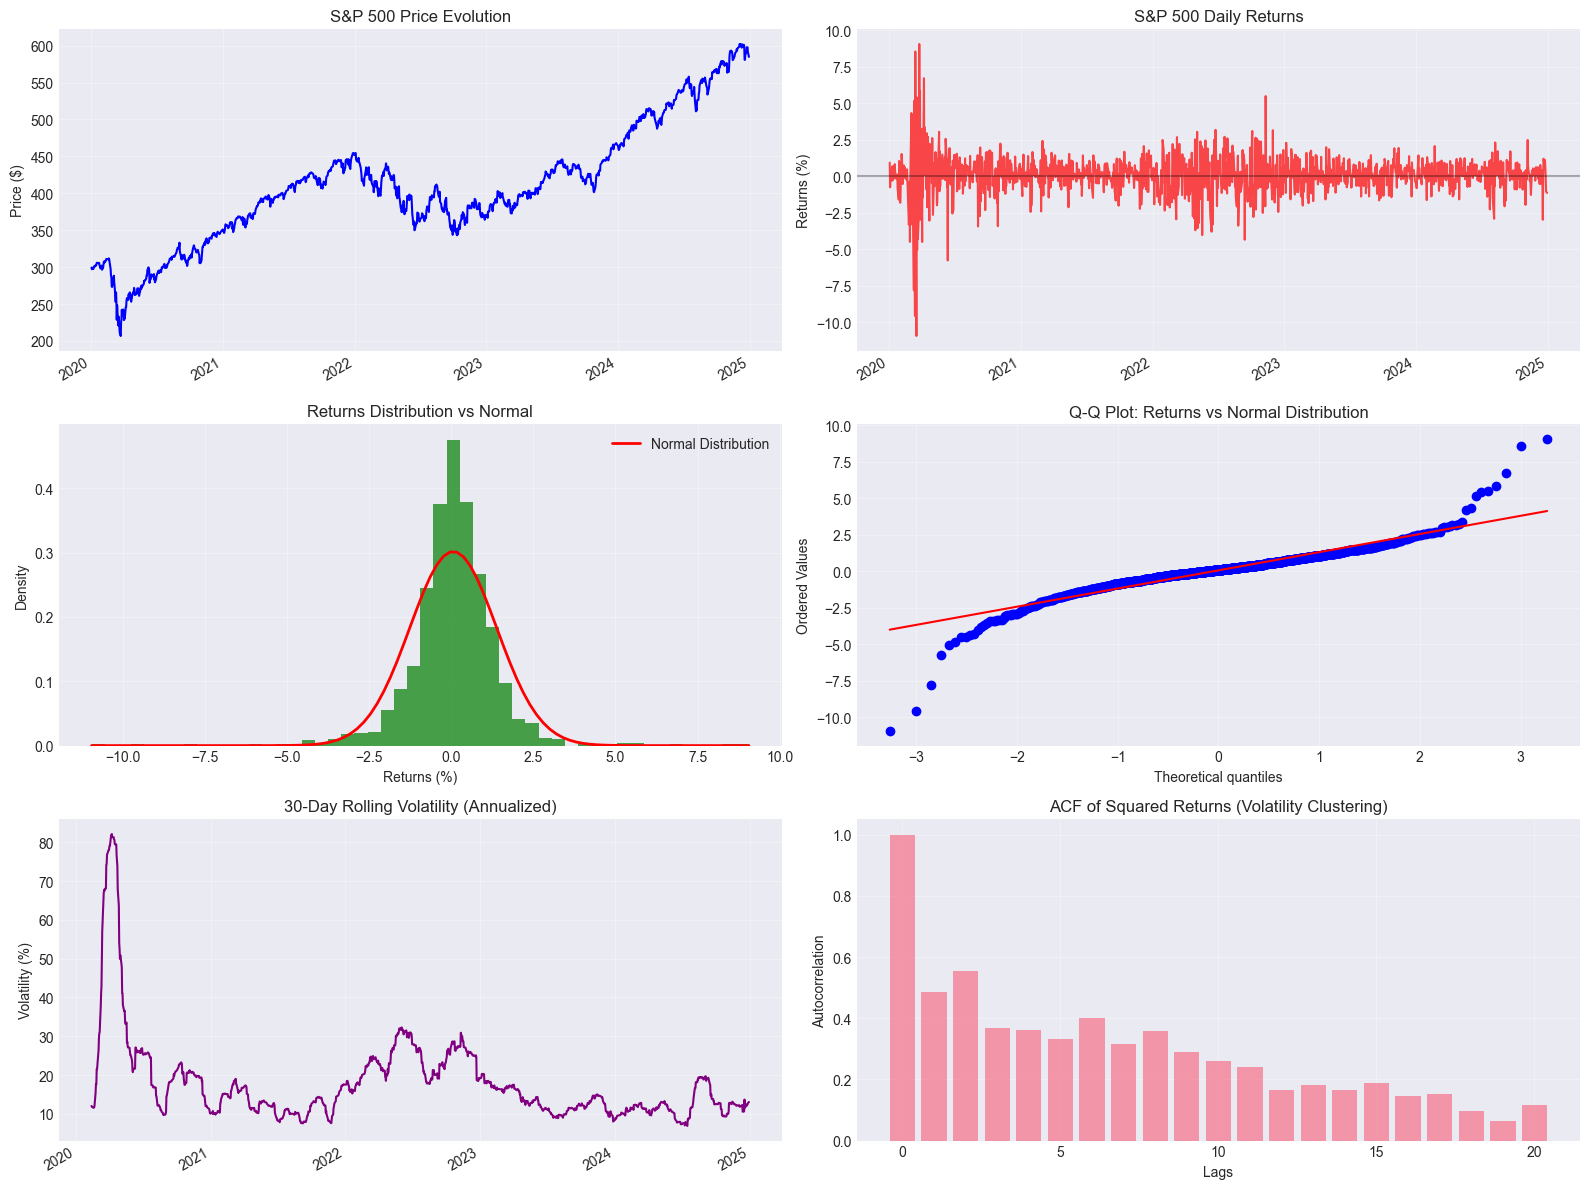


STATISTICAL TESTS
Jarque-Bera Test for Normality:
  Statistic: 6930.6603
  P-value: 0.000000
  Result: Reject normality

Ljung-Box Test for ARCH Effects (Volatility Clustering):
  P-value (lag 10): 0.000000
  Result: Significant ARCH effects detected


In [11]:
create_exploratory_plots(sp500_returns, prices_df)
#create a writeup : what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

#### 3. Univariate GARCH Model

In [12]:
print("\n" + "="*50)
print("SECTION 3: UNIVARIATE GARCH MODELING")
print("="*50)


SECTION 3: UNIVARIATE GARCH MODELING


In [13]:
"""
Fit various GARCH specifications and compare
"""
model_specs = {
        'GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal'},
        'GARCH(1,1)-t': {'p': 1, 'q': 1, 'dist': 't'},
        'GARCH(2,2)': {'p': 2, 'q': 2, 'dist': 'normal'},
        'EGARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'EGARCH'},
        'GJR-GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'GARCH', 'o': 1}
        }

In [14]:
# Function compares GARCH models and returns a DataFrame with results
def compare_garch_models(returns, model_specs):
    results_summary = []
    models = {}
    fitted_models = {}

    for name, specs in model_specs.items():
        vol_model = specs.get('vol', 'GARCH')
        model = arch_model(
                    returns, 
                    vol=vol_model, 
                    p=specs['p'], 
                    q=specs['q'],
                    o=specs.get('o', 0),
                    dist=specs['dist']
                    )
                    
        fitted = model.fit(disp='off')
        models[name] = model
        fitted_models[name] = fitted
                    
        # Store key metrics
        results_summary.append({
                    'Model': name,
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'Log-Likelihood': fitted.loglikelihood,
                    'Parameters': fitted.num_params
                    })

    # Create comparison table
    model_comparison = pd.DataFrame(results_summary)
    model_comparison = model_comparison.sort_values('AIC')
            
    # Select best model
    best_model_name = model_comparison.iloc[0]['Model']
    best_model = fitted_models[best_model_name]
            
    return fitted_models, model_comparison, best_model_name, best_model

In [15]:
fitted_models, model_comparison, best_model_name, best_model = compare_garch_models(sp500_returns, model_specs)

In [16]:
print("\nModel Comparison (sorted by AIC):") 
print(model_comparison.to_string(index=False))
print(f"\nBest model: {best_model_name}")


Model Comparison (sorted by AIC):
         Model         AIC         BIC  Log-Likelihood  Parameters
  GARCH(1,1)-t 3614.104916 3639.787332    -1802.052458           5
GJR-GARCH(1,1) 3637.199779 3662.882195    -1813.599889           5
    GARCH(1,1) 3658.671270 3679.217203    -1825.335635           4
    GARCH(2,2) 3660.994868 3691.813767    -1824.497434           6
   EGARCH(1,1) 3669.637863 3690.183795    -1830.818931           4

Best model: GARCH(1,1)-t


In [17]:
def model_diagnostics(model_name):
        """
        Comprehensive model diagnostics
        """
        if model_name is None:
            model_name = best_model_name
        
        fitted_model = fitted_models[model_name]
        
        print(f"\n{'='*60}")
        print(f"MODEL DIAGNOSTICS: {model_name}")
        print(f"{'='*60}")
        print(fitted_model.summary())
        
        # Extract residuals
        std_residuals = fitted_model.std_resid
        conditional_vol = fitted_model.conditional_volatility
        
        # Create diagnostic plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'GARCH Model Diagnostics: {model_name}', fontsize=16)
        
        # 1. Standardized residuals over time
        axes[0, 0].plot(std_residuals, alpha=0.7)
        axes[0, 0].set_title('Standardized Residuals')
        axes[0, 0].set_ylabel('Std. Residuals')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Conditional volatility
        axes[0, 1].plot(conditional_vol * np.sqrt(252), color='red')  # Annualized
        axes[0, 1].set_title('Conditional Volatility (Annualized)')
        axes[0, 1].set_ylabel('Volatility (%)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Residuals distribution
        axes[0, 2].hist(std_residuals, bins=50, density=True, alpha=0.7)
        x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
        axes[0, 2].plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
        axes[0, 2].set_title('Standardized Residuals Distribution')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Q-Q plot
        stats.probplot(std_residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot: Residuals vs Normal')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. ACF of standardized residuals
        acf_resid = acf(std_residuals, nlags=20, fft=True)
        axes[1, 1].bar(range(len(acf_resid)), acf_resid, alpha=0.7)
        axes[1, 1].set_title('ACF of Standardized Residuals')
        axes[1, 1].set_xlabel('Lags')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. ACF of squared standardized residuals
        acf_resid_sq = acf(std_residuals**2, nlags=20, fft=True)
        axes[1, 2].bar(range(len(acf_resid_sq)), acf_resid_sq, alpha=0.7, color='orange')
        axes[1, 2].set_title('ACF of Squared Std. Residuals')
        axes[1, 2].set_xlabel('Lags')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests on residuals
        print(f"\nResidual Diagnostics:")
        jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(std_residuals)
        print(f"Jarque-Bera (normality): {jb_stat:.4f} (p={jb_pvalue:.6f})")
        
        lb_test = acorr_ljungbox(std_residuals**2, lags=10, return_df=True)
        print(f"Ljung-Box on squared residuals (ARCH): {lb_test['lb_pvalue'].iloc[-1]:.6f}")
        
        #return fitted_model


MODEL DIAGNOSTICS: GARCH(1,1)-t
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1802.05
Distribution:      Standardized Student's t   AIC:                           3614.10
Method:                  Maximum Likelihood   BIC:                           3639.79
                                              No. Observations:                 1257
Date:                      Thu, Jul 31 2025   Df Residuals:                     1256
Time:                              09:06:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------------------

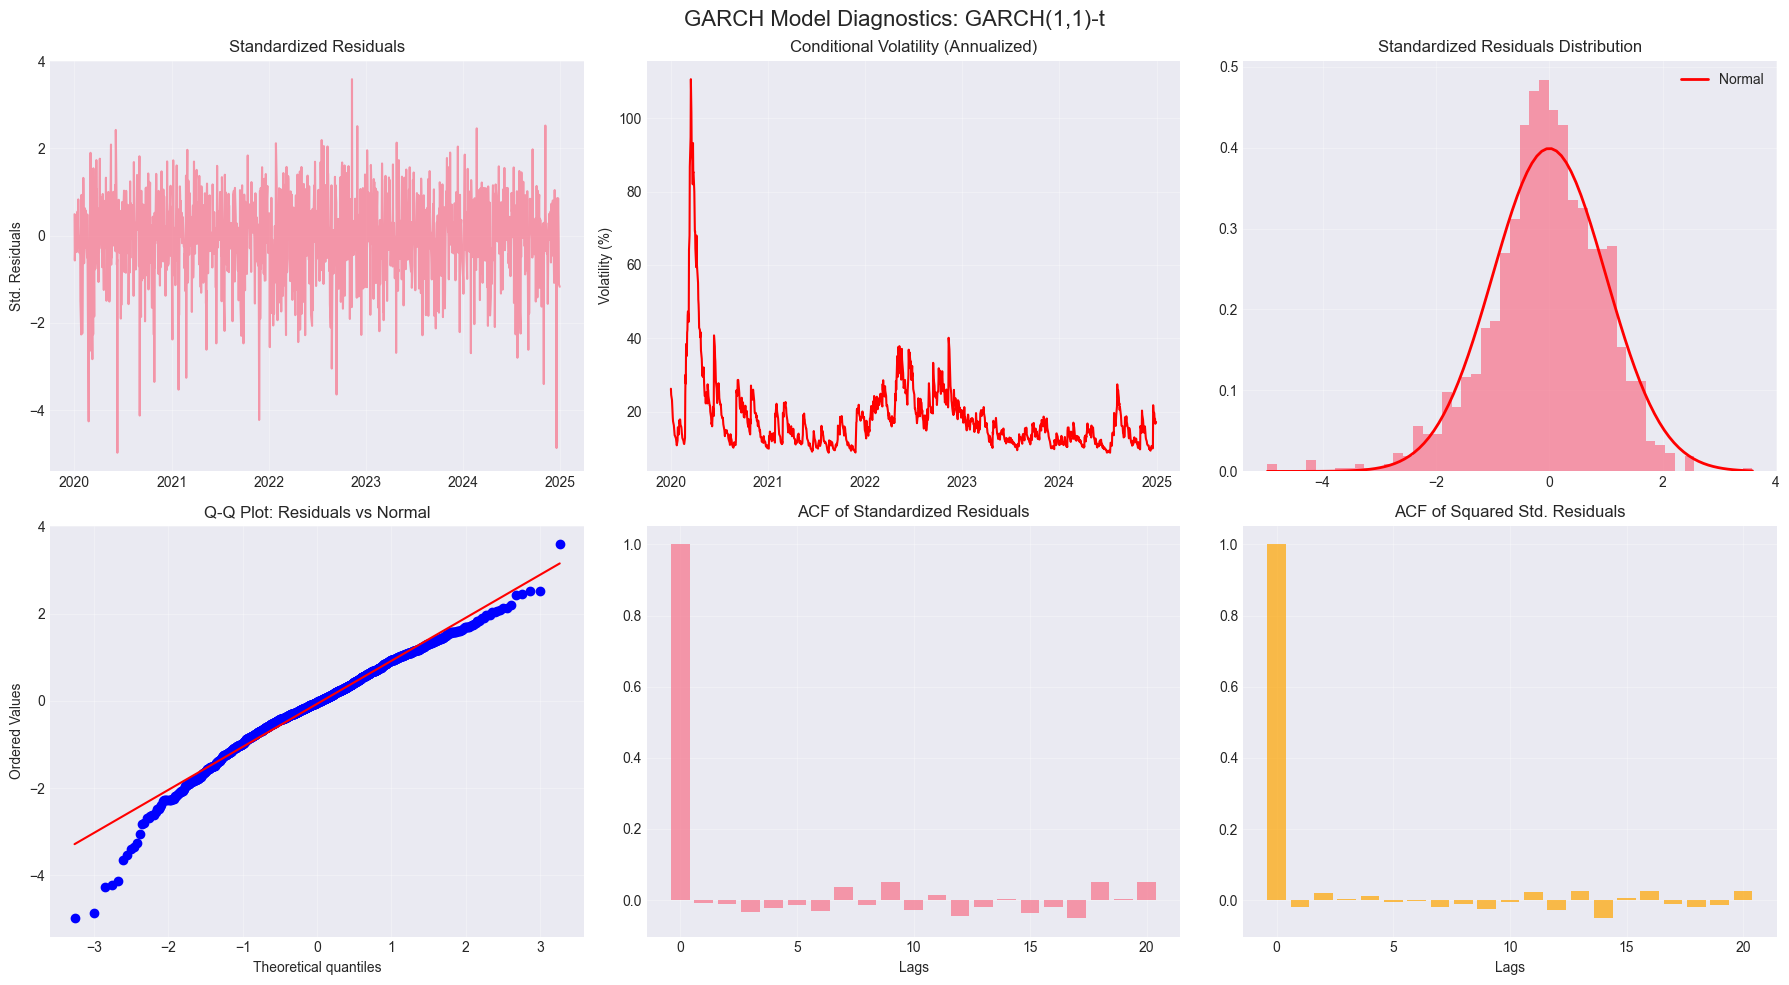


Residual Diagnostics:
Jarque-Bera (normality): 208.4697 (p=0.000000)
Ljung-Box on squared residuals (ARCH): 0.989380


In [18]:
model_diagnostics(best_model_name)
#create a writeup : what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

#### 4. Multivariate GARCH Model

In [19]:
print("\n" + "="*50)
print("SECTION 4: MULTIVARIATE GARCH MODELING")
print("="*50)


SECTION 4: MULTIVARIATE GARCH MODELING


In [20]:
def create_univariate_models(assets, returns):
    """
    Create univariate GARCH models for each asset in the DataFrame.
    Returns a dictionary of fitted models.
    """
    univariate_models = {}
    for asset in assets:
        model = arch_model(returns[asset], vol='GARCH', p=1, q=1, dist='t')
        fitted = model.fit(disp='off')
        univariate_models[asset] = fitted
    return univariate_models

In [21]:
asset_names = returns_df.columns.tolist()
univariate_models = create_univariate_models(asset_names, returns)

In [22]:
def generate_multivariate_garch_correlations(returns, asset_names, filter_date):
    """
    Manual DCC estimation (simplified version)
    """     
    # Get standardized residuals from univariate models
    std_residuals = pd.DataFrame()
    conditional_vols = pd.DataFrame()
        
    for asset in asset_names:
        std_residuals[asset] = univariate_models[asset].std_resid
        conditional_vols[asset] = univariate_models[asset].conditional_volatility
        
    # Simple DCC estimation using rolling correlation
    window = 60  # 3-month window
    n_assets = len(asset_names)
    n_obs = len(std_residuals)
        
    # Store dynamic correlations
    dynamic_correlations = np.zeros((n_obs, n_assets, n_assets))
    
    # Calculate correlations
    for t in range(window, n_obs):
            # Rolling correlation matrix
            recent_residuals = std_residuals.iloc[t-window:t]
            corr_matrix = recent_residuals.corr().values
            dynamic_correlations[t] = corr_matrix

    """
    Analyze the evolution of correlations over time
    """
    # Extract pairwise correlations
    spy_tlt_corr = [dynamic_correlations[t, 0, 1] for t in range(len(dynamic_correlations))]
    spy_gld_corr = [dynamic_correlations[t, 0, 2] for t in range(len(dynamic_correlations))]
    tlt_gld_corr = [dynamic_correlations[t, 1, 2] for t in range(len(dynamic_correlations))]
        
    # Create DataFrame for analysis
    corr_df = pd.DataFrame({
            'SPY_TLT': spy_tlt_corr,
            'SPY_GLD': spy_gld_corr,
            'TLT_GLD': tlt_gld_corr
        }, index=returns.index)
    corr_df_parsed = corr_df[corr_df.index >= filter_date]  # Filter by date
    
    conditional_vols = conditional_vols[conditional_vols.index >= filter_date]  # Filter by date
    std_residuals = std_residuals[std_residuals.index >= filter_date]  # Filter by date
    # Ensure the DataFrame is aligned with the returns index
        
   
    return corr_df, corr_df_parsed, conditional_vols
        

In [23]:
def plot_multivaraite_correlations(corr_df):
    # Plot dynamic correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dynamic Conditional Correlations (DCC-GARCH)', fontsize=16)
            
    # Time series of correlations
    axes[0, 0].plot(corr_df.index, corr_df['SPY_TLT'], label='SPY-TLT', alpha=0.8)
    axes[0, 0].plot(corr_df.index, corr_df['SPY_GLD'], label='SPY-GLD', alpha=0.8)
    axes[0, 0].plot(corr_df.index, corr_df['TLT_GLD'], label='TLT-GLD', alpha=0.8)
    axes[0, 0].set_title('Dynamic Correlations Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
    # Distribution of correlations
    axes[0, 1].hist(corr_df['SPY_TLT'], bins=30, alpha=0.6, label='SPY-TLT')
    axes[0, 1].hist(corr_df['SPY_GLD'], bins=30, alpha=0.6, label='SPY-GLD')  
    axes[0, 1].hist(corr_df['TLT_GLD'], bins=30, alpha=0.6, label='TLT-GLD')
    axes[0, 1].set_title('Distribution of Dynamic Correlations')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
            
    # Crisis periods analysis (high volatility periods)
    vix_data = returns_df['VXX'].loc[corr_df.index]
    high_vix_periods = vix_data > vix_data.quantile(0.8)
            
    axes[1, 0].scatter(vix_data, corr_df['SPY_TLT'], alpha=0.6, s=20)
    axes[1, 0].set_xlabel('VIX Level')
    axes[1, 0].set_ylabel('SPY-TLT Correlation')
    axes[1, 0].set_title('Correlation vs Market Stress (VIX)')
    axes[1, 0].grid(True, alpha=0.3)
            
    # Rolling average correlations
    rolling_corr = corr_df.rolling(window=60).mean()
    axes[1, 1].plot(rolling_corr.index, rolling_corr['SPY_TLT'], label='SPY-TLT (60d avg)')
    axes[1, 1].plot(rolling_corr.index, rolling_corr['SPY_GLD'], label='SPY-GLD (60d avg)')
    axes[1, 1].plot(rolling_corr.index, rolling_corr['TLT_GLD'], label='TLT-GLD (60d avg)')
    axes[1, 1].set_title('60-Day Rolling Average Correlations')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
            
    plt.tight_layout()
    plt.show()
            
    # Crisis analysis
    print(f"\nCorrelation During High VIX Periods (VIX > {vix_data.quantile(0.8):.1f}):")
    crisis_corr = corr_df[high_vix_periods]
    normal_corr = corr_df[~high_vix_periods]
            
    for pair in corr_df.columns:
        crisis_mean = crisis_corr[pair].mean()
        normal_mean = normal_corr[pair].mean()
        print(f"  {pair}: Crisis={crisis_mean:.3f}, Normal={normal_mean:.3f}, Difference={crisis_mean-normal_mean:.3f}")


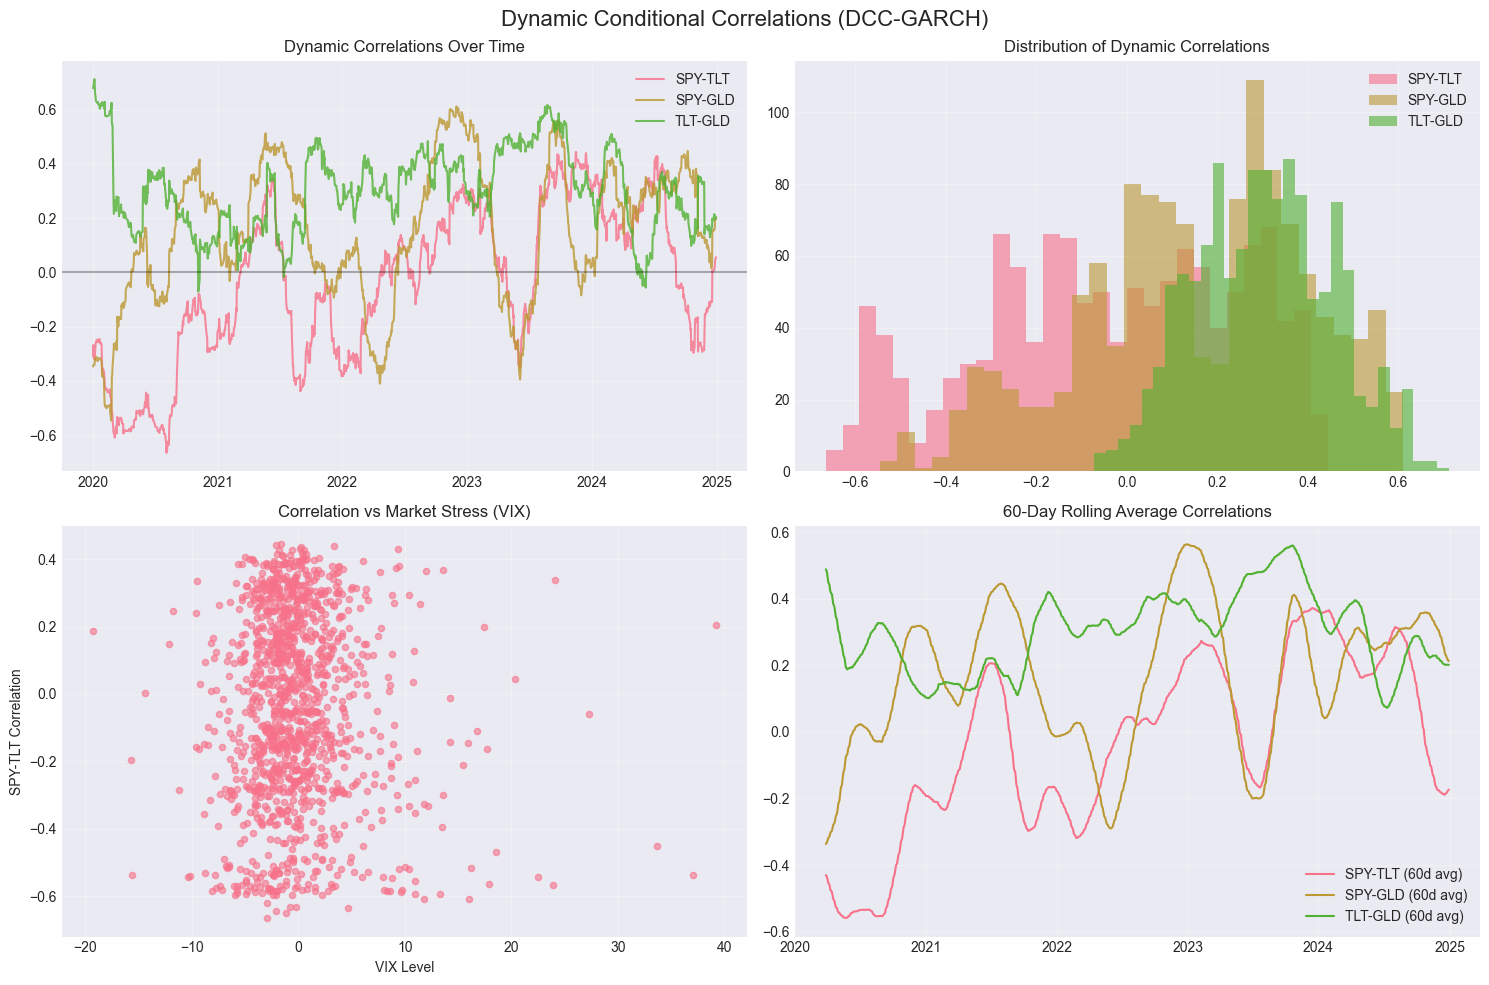


Correlation During High VIX Periods (VIX > 2.4):
  SPY_TLT: Crisis=-0.080, Normal=-0.034, Difference=-0.046
  SPY_GLD: Crisis=0.140, Normal=0.155, Difference=-0.015
  TLT_GLD: Crisis=0.303, Normal=0.304, Difference=-0.001


In [24]:
corr_df, corr_df_parsed, conditional_vols = generate_multivariate_garch_correlations(returns, asset_names, filter_date)
plot_multivaraite_correlations(corr_df_parsed)
# Create a writeup: what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

In [25]:
def plot_conditional_volatility(conditional_vols):
    """
    Apply DCC results to portfolio optimization
    """
    print(f"\nPortfolio Optimization Using Dynamic Correlations:")

    # Equal weight portfolio
    weights = np.array([1/3, 1/3, 1/3])  # Equal weights for SPY, TLT, GLD

    # Ensure conditional_vols order matches weights order (SPY, TLT, GLD)
    conditional_vols_ordered = conditional_vols[['SPY', 'TLT', 'GLD']]  # Match weight order

    # Calculate portfolio volatility over time
    portfolio_variance = []
    portfolio_vol = []

    # Calculate average correlations over the period
    avg_spy_tlt = corr_df['SPY_TLT'].mean()
    avg_spy_gld = corr_df['SPY_GLD'].mean() 
    avg_tlt_gld = corr_df['TLT_GLD'].mean()

    print(f"Average correlations:")
    print(f"  SPY-TLT: {avg_spy_tlt:.3f}")
    print(f"  SPY-GLD: {avg_spy_gld:.3f}")
    print(f"  TLT-GLD: {avg_tlt_gld:.3f}")

    # Fixed correlation matrix
    avg_corr_matrix = np.array([
        [1.0,        avg_spy_tlt, avg_spy_gld],
        [avg_spy_tlt, 1.0,        avg_tlt_gld],
        [avg_spy_gld, avg_tlt_gld, 1.0       ]
    ])

    # Time-varying volatilities with fixed correlations
    portfolio_vol_simple = []
    for date in conditional_vols_ordered.index:
        vol_vector = conditional_vols_ordered.loc[date].values / 100
        vol_matrix = np.outer(vol_vector, vol_vector)
        cov_matrix = avg_corr_matrix * vol_matrix
        port_var = weights.T @ cov_matrix @ weights
        portfolio_vol_simple.append(np.sqrt(port_var * 252) * 100)

    portfolio_vol_series = pd.Series(portfolio_vol_simple, index=conditional_vols_ordered.index)

    # Compare with equal-weighted historical volatility (only investable assets)
    investable_returns = returns[['SPY', 'TLT', 'GLD']]  # Exclude VIX
    equal_weight_returns = investable_returns.mean(axis=1)  # Equal weight portfolio returns
    hist_vol = equal_weight_returns.rolling(60).std() * np.sqrt(252)

    # Plot comparison
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_vol_series.index, portfolio_vol_series, 
            label='DCC-GARCH Portfolio Volatility', linewidth=2, color='blue')
    plt.plot(hist_vol.index, hist_vol, 
            label='Historical 60-day Rolling Volatility', alpha=0.7, color='orange')
    plt.title('Portfolio Volatility: DCC-GARCH vs Historical Methods')
    plt.ylabel('Annualized Volatility (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Average Portfolio Volatility (DCC): {portfolio_vol_series.mean():.2f}%")
    print(f"Average Portfolio Volatility (Historical): {hist_vol.dropna().mean():.2f}%")

    # Additional analysis
    print(f"\nPortfolio Analysis:")
    print(f"Number of observations: {len(portfolio_vol_series)}")
    print(f"Date range: {portfolio_vol_series.index[0].strftime('%Y-%m-%d')} to {portfolio_vol_series.index[-1].strftime('%Y-%m-%d')}")

    # Show volatility statistics
    print(f"\nVolatility Statistics:")
    print(f"DCC Portfolio Volatility:")
    print(f"  Mean: {portfolio_vol_series.mean():.2f}%")
    print(f"  Std:  {portfolio_vol_series.std():.2f}%")
    print(f"  Min:  {portfolio_vol_series.min():.2f}%")
    print(f"  Max:  {portfolio_vol_series.max():.2f}%")
    return portfolio_vol_series


Portfolio Optimization Using Dynamic Correlations:
Average correlations:
  SPY-TLT: -0.042
  SPY-GLD: 0.145
  TLT-GLD: 0.290


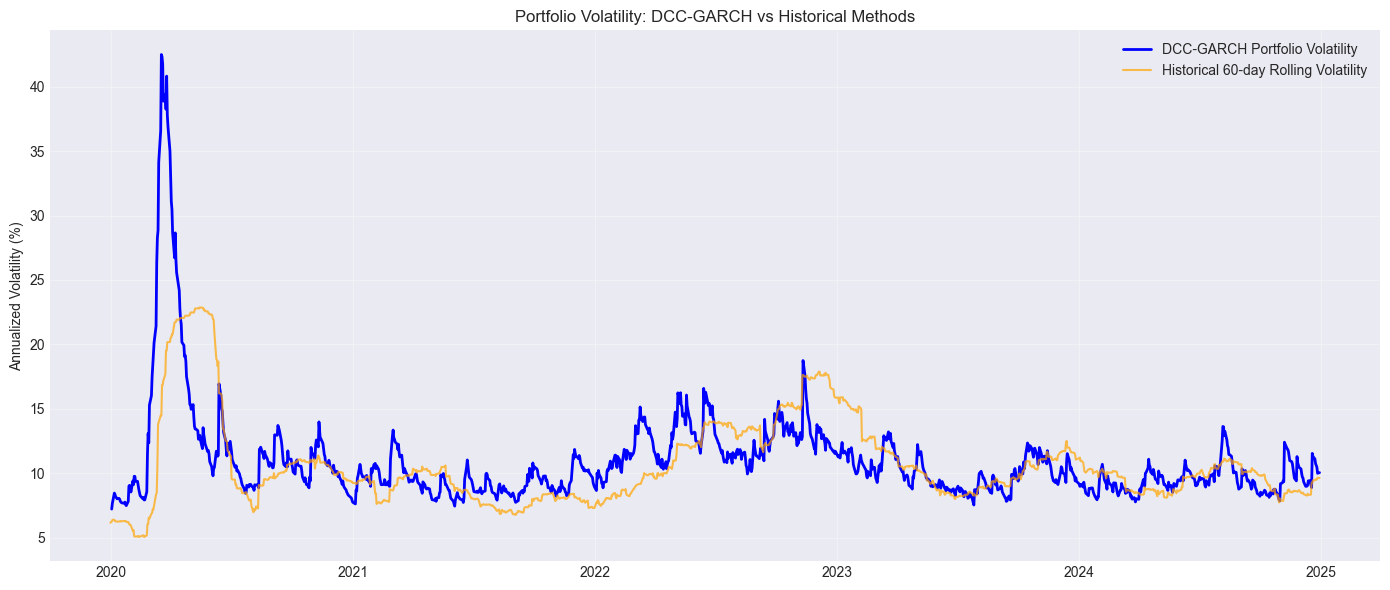

Average Portfolio Volatility (DCC): 10.95%
Average Portfolio Volatility (Historical): 10.66%

Portfolio Analysis:
Number of observations: 1257
Date range: 2020-01-02 to 2024-12-30

Volatility Statistics:
DCC Portfolio Volatility:
  Mean: 10.95%
  Std:  3.85%
  Min:  7.22%
  Max:  42.49%


2020-01-02     7.220731
2020-01-03     7.663375
2020-01-06     8.460043
2020-01-07     8.354543
2020-01-08     8.164549
                ...    
2024-12-23    11.113840
2024-12-24    10.753672
2024-12-26    10.468055
2024-12-27     9.999121
2024-12-30    10.050365
Length: 1257, dtype: float64

In [26]:
plot_conditional_volatility(conditional_vols)

#### 5. Rolling Window Forecast

In [27]:
print("\n" + "="*50)
print("SECTION 5: ROLLING WINDOW FORECASTING")
print("="*50)


SECTION 5: ROLLING WINDOW FORECASTING


In [28]:
def simple_rolling_forecast(returns, window_size=252, forecast_horizon=30, step=10):
    """
    Simple rolling window GARCH forecasting
    
    Parameters:
    - returns: pandas Series of daily returns
    - window_size: size of rolling window (default 252 = 1 year)
    - forecast_horizon: days ahead to forecast (default 30)
    - step: how often to forecast (default every 10 days)
    """
    
    print(f"Simple Rolling GARCH Forecast")
    print(f"Window size: {window_size} days")
    print(f"Forecast horizon: {forecast_horizon} days")
    print(f"Forecasting every {step} days")
    print("-" * 40)
    
    # Storage for results
    forecast_dates = []
    volatility_forecasts = []
    actual_volatilities = []
    
    # Start after we have enough data for window
    start_idx = window_size
    end_idx = len(returns) - forecast_horizon
    
    # Simple for loop
    for i in range(start_idx, end_idx, step):
        
        # Get window data
        window_data = returns.iloc[i-window_size:i]
        forecast_date = returns.index[i]
        
        try:
            # Fit GARCH model
            model = arch_model(window_data, vol='GARCH', p=1, q=1, dist='t')
            fitted = model.fit(disp='off')
            
            # Get forecast
            forecast = fitted.forecast(horizon=forecast_horizon)
            vol_forecast = np.sqrt(forecast.variance.iloc[0, 0] * 252)  # Annualized
            
            # Get actual future volatility
            future_data = returns.iloc[i:i+forecast_horizon]
            actual_vol = future_data.std() * np.sqrt(252)  # Annualized
            
            # Store results
            forecast_dates.append(forecast_date)
            volatility_forecasts.append(vol_forecast)
            actual_volatilities.append(actual_vol)
            
            print(f"{forecast_date.strftime('%Y-%m-%d')}: Forecast={vol_forecast:.2f}%, Actual={actual_vol:.2f}%")
            
        except Exception as e:
            print(f"Error at {forecast_date}: {e}")
            continue
    
    # Create DataFrame
    forecast_df = pd.DataFrame({
        'Volatility_Forecast': volatility_forecasts,
        'Actual_Volatility': actual_volatilities
    }, index=forecast_dates)
    
    print(f"\n✓ Generated {len(forecast_df)} forecasts")
    return forecast_df

In [29]:
def evaluate_forecast_accuracy(returns, forecast_df):
    """
    Evaluate the accuracy of rolling forecasts
    """
    print("\nEvaluating Forecast Accuracy...")
        
    # Remove NaN values
    valid_data = forecast_df.dropna()
        
    forecasts = valid_data['Volatility_Forecast']
    actuals = valid_data['Actual_Volatility']
        
    # Calculate accuracy metrics
    mae = np.mean(np.abs(forecasts - actuals))
    rmse = np.sqrt(np.mean((forecasts - actuals)**2))
    mape = np.mean(np.abs((forecasts - actuals) / actuals)) * 100
    correlation = np.corrcoef(forecasts, actuals)[0, 1]
        
    # Direction accuracy (whether forecast correctly predicted increase/decrease)
    prev_vol = returns.rolling(30).std().iloc[-len(valid_data):] * np.sqrt(252) * 100
    actual_direction = (actuals > prev_vol.values).astype(int)
    forecast_direction = (forecasts > prev_vol.values).astype(int)
    direction_accuracy = np.mean(actual_direction == forecast_direction) * 100
        
    # Store accuracy metrics
    accuracy_metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Correlation': correlation,
            'Direction_Accuracy': direction_accuracy,
            'N_Observations': len(valid_data)
        }
        
    print(f"Forecast Accuracy Metrics:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}%")
    print(f"  Root Mean Square Error (RMSE): {rmse:.3f}%")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  Direction Accuracy: {direction_accuracy:.2f}%")
    print(f"  Number of Observations: {len(valid_data)}")
        
    return accuracy_metrics

In [30]:
def plot_forecast_analysis(forecast_df, ):
    """
    Create comprehensive forecast analysis plots
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Rolling Window GARCH Forecast Analysis', fontsize=16)
        
    # Remove NaN values for plotting
    valid_data = forecast_df.dropna()
        
    if len(valid_data) == 0:
        print("No valid data for plotting.")
        return
        
    # 1. Forecast vs Actual over time
    axes[0, 0].plot(valid_data.index, valid_data['Volatility_Forecast'], 
                       label='GARCH Forecast', alpha=0.8, linewidth=2)
    axes[0, 0].plot(valid_data.index, valid_data['Actual_Volatility'], 
                       label='Realized Volatility', alpha=0.8, linewidth=2)
    axes[0, 0].set_title('Volatility Forecasts vs Realized Volatility')
    axes[0, 0].set_ylabel('Annualized Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
        
    # 2. Scatter plot: Forecast vs Actual
    axes[0, 1].scatter(valid_data['Volatility_Forecast'], valid_data['Actual_Volatility'], 
                          alpha=0.6, s=30)
        
    # Add perfect forecast line
    min_val = min(valid_data['Volatility_Forecast'].min(), valid_data['Actual_Volatility'].min())
    max_val = max(valid_data['Volatility_Forecast'].max(), valid_data['Actual_Volatility'].max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Forecast')
        
    axes[0, 1].set_xlabel('Forecast Volatility (%)')
    axes[0, 1].set_ylabel('Actual Volatility (%)')
    axes[0, 1].set_title('Forecast vs Actual Volatility')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
        
    # 3. Forecast errors over time
    forecast_errors = valid_data['Volatility_Forecast'] - valid_data['Actual_Volatility']
    axes[1, 0].plot(valid_data.index, forecast_errors, alpha=0.7, color='red')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].set_title('Forecast Errors Over Time')
    axes[1, 0].set_ylabel('Forecast Error (%)')
    axes[1, 0].grid(True, alpha=0.3)
        
    # 4. Distribution of forecast errors
    axes[1, 1].hist(forecast_errors, bins=30, alpha=0.7, density=True, color='orange')
    axes[1, 1].axvline(forecast_errors.mean(), color='red', linestyle='--', 
                          label=f'Mean: {forecast_errors.mean():.3f}%')
    axes[1, 1].set_title('Distribution of Forecast Errors')
    axes[1, 1].set_xlabel('Forecast Error (%)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
        
    return valid_data

In [31]:
forecast_df = simple_rolling_forecast(returns_df['SPY'], window_size=252, forecast_horizon=30, step=10)

Simple Rolling GARCH Forecast
Window size: 252 days
Forecast horizon: 30 days
Forecasting every 10 days
----------------------------------------
2020-12-31: Forecast=10.67%, Actual=15.09%
2021-01-15: Forecast=13.01%, Actual=17.39%
2021-02-01: Forecast=28.24%, Actual=16.34%
2021-02-16: Forecast=13.32%, Actual=16.68%
2021-03-02: Forecast=21.91%, Actual=13.54%
2021-03-16: Forecast=16.42%, Actual=11.46%
2021-03-30: Forecast=15.29%, Actual=10.60%
2021-04-14: Forecast=11.95%, Actual=13.41%
2021-04-28: Forecast=13.32%, Actual=12.06%
2021-05-12: Forecast=14.89%, Actual=12.21%
2021-05-26: Forecast=14.32%, Actual=8.23%
2021-06-10: Forecast=11.00%, Actual=10.90%
2021-06-24: Forecast=13.20%, Actual=10.09%
2021-07-09: Forecast=13.08%, Actual=10.19%
2021-07-23: Forecast=13.36%, Actual=8.03%
2021-08-06: Forecast=11.74%, Actual=8.26%
2021-08-20: Forecast=12.84%, Actual=12.58%
2021-09-03: Forecast=9.26%, Actual=14.16%
2021-09-20: Forecast=13.33%, Actual=13.82%
2021-10-04: Forecast=17.04%, Actual=9.61%


In [32]:
evaluate_forecast_accuracy(returns_df['SPY'], forecast_df)


Evaluating Forecast Accuracy...
Forecast Accuracy Metrics:
  Mean Absolute Error (MAE): 3.918%
  Root Mean Square Error (RMSE): 4.922%
  Mean Absolute Percentage Error (MAPE): 26.43%
  Correlation: 0.6867
  Direction Accuracy: 100.00%
  Number of Observations: 98


{'MAE': 3.9177580497776483,
 'RMSE': 4.922394046111131,
 'MAPE': 26.42842547270497,
 'Correlation': 0.6866832348974241,
 'Direction_Accuracy': 100.0,
 'N_Observations': 98}

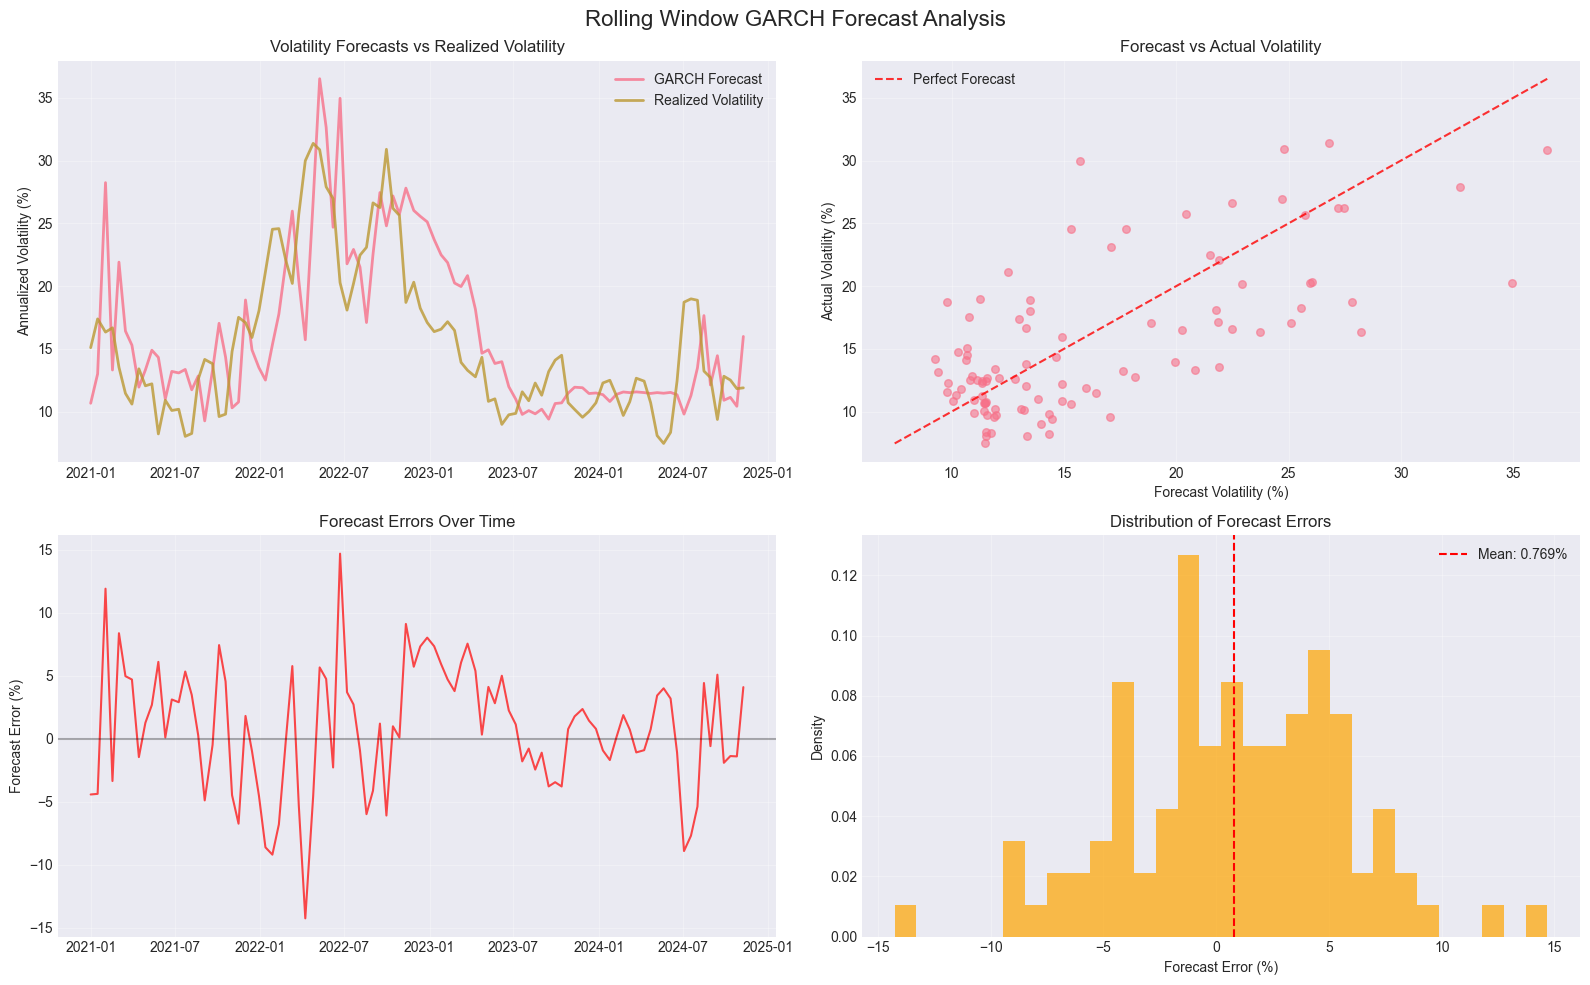

,Volatility_Forecast,Actual_Volatility
2020-12-31,10.666828,15.094922
2021-01-15,13.009151,17.387831
2021-02-01,28.242275,16.336778
2021-02-16,13.316422,16.676188
2021-03-02,21.909158,13.538013
...,...,...
2024-09-13,14.455022,9.375735
2024-09-27,10.905954,12.820220
2024-10-11,11.137445,12.515732
2024-10-25,10.425922,11.831633


In [33]:
plot_forecast_analysis(forecast_df)

#### 6. RISK MANAGEMENT APPLICATIONS

In [34]:
print("\n" + "="*50)
print("SECTION 5: RISK MANAGEMENT APPLICATIONS")
print("="*50)


SECTION 5: RISK MANAGEMENT APPLICATIONS


In [35]:
def calculate_dynamic_var(garch_model, confidence_levels=[0.95, 0.99], horizon=1, distribution='t'):
    """
    Simple dynamic VaR calculation using GARCH forecasts
    """
    
    print(f"Calculating Dynamic VaR ({horizon}-day horizon)")
    print(f"Confidence levels: {[int(cl*100) for cl in confidence_levels]}%")
    print(f"Distribution: {distribution}")
    print("-" * 50)
    
    # Get volatility forecast
    forecast = garch_model.forecast(horizon=horizon)
    vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])  # Already in % if returns were in %
    
    print(f"Volatility forecast: {vol_forecast:.3f}%")
    
    # Calculate VaR for each confidence level
    var_results = {}
    
    for conf_level in confidence_levels:
        
        # Calculate quantiles
        if distribution == 'normal':
            quantile = stats.norm.ppf(1 - conf_level)
        elif distribution == 't':
            df = 6  # Typical degrees of freedom for financial data
            quantile = stats.t.ppf(1 - conf_level, df)
        else:
            quantile = stats.norm.ppf(1 - conf_level)  # Default to normal
        
        # Calculate VaR (no extra *100 since vol_forecast is already in %)
        var_value = quantile * vol_forecast
        
        # Store results
        var_results[conf_level] = {
            'VaR': var_value,
            'Volatility_Forecast': vol_forecast,
            'Quantile': quantile
        }
        
        # Print results
        print(f"{conf_level*100:.0f}% VaR: {var_value:.3f}%")
    
    print("-" * 50)
    
    return var_results

In [36]:
def calculate_portfolio_var(garch_model, portfolio_value, confidence_levels=[0.95, 0.99], 
                          horizon=1, distribution='t'):
    """
    Calculate portfolio VaR in dollar terms
    """
    
    # Get percentage VaR
    var_results = calculate_dynamic_var(garch_model, confidence_levels, horizon, distribution)
    
    print(f"\nPortfolio VaR (Portfolio Value: ${portfolio_value:,.0f})")
    print("-" * 50)
    
    # Convert to dollar terms
    for conf_level in confidence_levels:
        var_pct = var_results[conf_level]['VaR']
        var_dollar = abs(var_pct / 100 * portfolio_value)  # var_pct already in %, so divide by 100
        
        var_results[conf_level]['VaR_Dollar'] = var_dollar
        
        print(f"{conf_level*100:.0f}% VaR: {var_pct:.3f}% = ${var_dollar:,.0f}")
    
    print("-" * 50)
    
    return var_results

In [37]:
def create_var_summary_table(var_results):
    """
    Create a clean summary table of VaR results
    """
    
    # Convert to DataFrame for nice display
    summary_data = []
    
    for conf_level, results in var_results.items():
        row = {
            'Confidence Level': f"{conf_level*100:.0f}%",
            'VaR (%)': f"{results['VaR']:.3f}%",
            'Volatility Forecast (%)': f"{results['Volatility_Forecast']:.3f}%"
        }
        
        # Add dollar VaR if available
        if 'VaR_Dollar' in results:
            row['VaR ($)'] = f"${results['VaR_Dollar']:,.0f}"
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\nVaR Summary Table:")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    print("=" * 60)

    # Add interpretation
    print("\nInterpretation:")
    for conf_level, results in var_results.items():
        prob = (1 - conf_level) * 100
        var_pct = abs(results['VaR'])
        if 'VaR_Dollar' in results:
            var_dollar = results['VaR_Dollar']
            print(f"• {prob:.0f}% chance of daily loss exceeding {var_pct:.2f}% (${var_dollar:,.0f})")
        else:
            print(f"• {prob:.0f}% chance of daily loss exceeding {var_pct:.2f}%")
    
    return summary_df

In [38]:
var_results = calculate_portfolio_var(best_model, portfolio_value=1000000, 
                        confidence_levels=[0.95, 0.99], horizon=1, distribution='t')

Calculating Dynamic VaR (1-day horizon)
Confidence levels: [95, 99]%
Distribution: t
--------------------------------------------------
Volatility forecast: 1.117%
95% VaR: -2.171%
99% VaR: -3.511%
--------------------------------------------------

Portfolio VaR (Portfolio Value: $1,000,000)
--------------------------------------------------
95% VaR: -2.171% = $21,708
99% VaR: -3.511% = $35,109
--------------------------------------------------


In [39]:
var_summary_df = create_var_summary_table(var_results)


VaR Summary Table:
Confidence Level VaR (%) Volatility Forecast (%) VaR ($)
             95% -2.171%                  1.117% $21,708
             99% -3.511%                  1.117% $35,109

Interpretation:
• 5% chance of daily loss exceeding 2.17% ($21,708)
• 1% chance of daily loss exceeding 3.51% ($35,109)


In [40]:
def calculate_scenario_var(volatility_pct, confidence_level, distribution='t'):
    """
    Calculate VaR for a given volatility scenario
    
    Parameters:
    - volatility_pct: Annual volatility percentage
    - confidence_level: Confidence level (e.g., 0.95)
    - distribution: 't' or 'normal'
    """
    
    # Convert annual volatility to daily
    daily_vol = volatility_pct / np.sqrt(252)
    
    # Calculate quantile
    if distribution == 't':
        df = 6  # Standard assumption for financial data
        quantile = stats.t.ppf(1 - confidence_level, df)
    else:
        quantile = stats.norm.ppf(1 - confidence_level)
    
    # Daily VaR
    daily_var = quantile * daily_vol
    
    return daily_var

In [41]:
def calculate_scenario_var_from_daily(daily_vol_pct, confidence_level, distribution='t'):
    """
    Calculate VaR directly from daily volatility percentage
    """
    
    # Calculate quantile
    if distribution == 't':
        df = 6  # Standard assumption for financial data
        quantile = stats.t.ppf(1 - confidence_level, df)
    else:
        quantile = stats.norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    var_value = quantile * daily_vol_pct
    
    return var_value

In [42]:
def display_stress_results(scenarios):
    """
    Display stress test results in a clean format
    """
    
    print("\nSTRESS TEST RESULTS")
    print("-" * 80)
    
    for scenario_name, scenario in scenarios.items():
        print(f"\n{scenario_name.replace('_', ' ').upper()}:")
        print(f"  Description: {scenario['description']}")
        print(f"  Annual Volatility: {scenario['volatility']:.1f}%")
        print(f"  95% Daily VaR: {scenario['var_95']:.2f}% (${scenario['var_95_dollar']:,.0f})")
        print(f"  99% Daily VaR: {scenario['var_99']:.2f}% (${scenario['var_99_dollar']:,.0f})")
        print(f"  Expected Annual Loss: {scenario['expected_annual_loss']:.1f}% (${scenario['annual_loss_dollar']:,.0f})")
    
    print("\n" + "="*80)

In [43]:
def simple_stress_testing(garch_model, returns_data, portfolio_value=1000000):
    """
    Simple stress testing scenarios using GARCH model
    """
    
    print("STRESS TESTING SCENARIOS")
    print("="*60)
    print(f"Portfolio Value: ${portfolio_value:,.0f}")
    print("="*60)
    
     # Get 1-day forecast (same as dynamic VaR)
    single_day_forecast = garch_model.forecast(horizon=1)
    base_daily_vol = np.sqrt(single_day_forecast.variance.iloc[-1, 0])
    
    # Current market conditions
    current_vol = returns_data.tail(30).std() * np.sqrt(252)  # Last 30 days annualized
    
    scenarios = {}
    base_annual_vol = base_daily_vol * np.sqrt(252)
    scenarios['Base_Case'] = {
        'description': 'Normal market conditions (1-day GARCH forecast)',
        'volatility': base_annual_vol,  # Use daily vol directly
        'var_95': calculate_scenario_var_from_daily(base_daily_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(base_daily_vol, 0.99),
        'expected_annual_loss': base_annual_vol * 0.4
    }
    
    # Scenario 2: Moderate Stress (1.5x current volatility)
    moderate_stress_vol = current_vol * 1.5
    scenarios['Moderate_Stress'] = {
        'description': '1.5x current market volatility',
        'volatility': moderate_stress_vol,
        'var_95': calculate_scenario_var_from_daily(moderate_stress_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(moderate_stress_vol, 0.99),
        'expected_annual_loss': moderate_stress_vol * 0.4
    }
    
    # Scenario 3: Severe Stress (2008-like crisis)
    crisis_vol = 45.0  # Typical 2008 crisis volatility
    scenarios['Crisis_2008'] = {
        'description': '2008-style financial crisis (45% volatility)',
        'volatility': crisis_vol,
        'var_95': calculate_scenario_var_from_daily(crisis_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(crisis_vol, 0.99),
        'expected_annual_loss': crisis_vol * 0.6  # Higher loss rate in crisis
    }
    
    # Scenario 4: Extreme Stress (COVID-like event)
    covid_vol = 60.0  # March 2020 levels
    scenarios['Extreme_COVID'] = {
        'description': 'COVID-style market shock (60% volatility)',
        'volatility': covid_vol,
        'var_95': calculate_scenario_var_from_daily(covid_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(covid_vol, 0.99),
        'expected_annual_loss': covid_vol * 0.8  # Very high loss rate
    }
    
    # Calculate dollar impacts
    for scenario_name, scenario in scenarios.items():
        scenario['var_95_dollar'] = abs(scenario['var_95'] / 100 * portfolio_value)
        scenario['var_99_dollar'] = abs(scenario['var_99'] / 100 * portfolio_value)
        scenario['annual_loss_dollar'] = scenario['expected_annual_loss'] / 100 * portfolio_value
    
    # Display results
    display_stress_results(scenarios)
    
    
    return scenarios

In [44]:
simple_stress_testing(best_model, returns_df['SPY'], portfolio_value=1000000)

STRESS TESTING SCENARIOS
Portfolio Value: $1,000,000

STRESS TEST RESULTS
--------------------------------------------------------------------------------

BASE CASE:
  Description: Normal market conditions (1-day GARCH forecast)
  Annual Volatility: 17.7%
  95% Daily VaR: -2.17% ($21,708)
  99% Daily VaR: -3.51% ($35,109)
  Expected Annual Loss: 7.1% ($70,937)

MODERATE STRESS:
  Description: 1.5x current market volatility
  Annual Volatility: 19.6%
  95% Daily VaR: -38.02% ($380,175)
  99% Daily VaR: -61.49% ($614,850)
  Expected Annual Loss: 7.8% ($78,258)

CRISIS 2008:
  Description: 2008-style financial crisis (45% volatility)
  Annual Volatility: 45.0%
  95% Daily VaR: -87.44% ($874,431)
  99% Daily VaR: -141.42% ($1,414,201)
  Expected Annual Loss: 27.0% ($270,000)

EXTREME COVID:
  Description: COVID-style market shock (60% volatility)
  Annual Volatility: 60.0%
  95% Daily VaR: -116.59% ($1,165,908)
  99% Daily VaR: -188.56% ($1,885,601)
  Expected Annual Loss: 48.0% ($480,000

{'Base_Case': {'description': 'Normal market conditions (1-day GARCH forecast)',
  'volatility': 17.734332405627537,
  'var_95': -2.1708392667411975,
  'var_99': -3.51085693954857,
  'expected_annual_loss': 7.093732962251015,
  'var_95_dollar': 21708.392667411976,
  'var_99_dollar': 35108.5693954857,
  'annual_loss_dollar': 70937.32962251015},
 'Moderate_Stress': {'description': '1.5x current market volatility',
  'volatility': 19.564595846833342,
  'var_95': -38.01753684342106,
  'var_99': -61.48503719100118,
  'expected_annual_loss': 7.8258383387333375,
  'var_95_dollar': 380175.3684342106,
  'var_99_dollar': 614850.3719100117,
  'annual_loss_dollar': 78258.38338733338},
 'Crisis_2008': {'description': '2008-style financial crisis (45% volatility)',
  'volatility': 45.0,
  'var_95': -87.44311261767517,
  'var_99': -141.42007814809435,
  'expected_annual_loss': 27.0,
  'var_95_dollar': 874431.1261767517,
  'var_99_dollar': 1414200.7814809433,
  'annual_loss_dollar': 270000.0},
 'Extre

In [45]:
def print_dashboard_summary(garch_model, returns_data, var_95, var_99):
    """
    Print key risk metrics summary
    """
    
    print("\n" + "="*60)
    print("RISK DASHBOARD SUMMARY")
    print("="*60)
    
    # Current metrics
    current_forecast = garch_model.forecast(horizon=1)
    current_vol = np.sqrt(current_forecast.variance.iloc[-1, 0] * 252)
      # Historical metrics
    hist_vol_30d = returns_data.tail(30).std() * np.sqrt(252)
    hist_vol_1y = returns_data.tail(252).std() * np.sqrt(252)
    
    print(f"Current Volatility Forecast: {current_vol:.2f}%")
    print(f"30-Day Realized Volatility: {hist_vol_30d:.2f}%")
    print(f"1-Year Realized Volatility: {hist_vol_1y:.2f}%")
    print(f"\n95% VaR (1-day): {abs(var_95):.2f}%")
    print(f"99% VaR (1-day): {abs(var_99):.2f}%")
    
    # Risk assessment
    print(f"\nRisk Assessment:")
    if current_vol > hist_vol_1y * 1.5:
        print("⚠️  HIGH RISK: Current volatility significantly above historical average")
    elif current_vol > hist_vol_1y * 1.2:
        print("🟡 MODERATE RISK: Current volatility elevated")
    else:
        print("✅ NORMAL RISK: Current volatility within normal range")
    
    print("="*60)

In [46]:
def create_simple_risk_dashboard(garch_model, returns_data, title="GARCH Risk Management Dashboard"):
    """
    Create a clean, simple risk management dashboard
    """
    
    print(f"Creating {title}...")
    
    # Set up the dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Historical Volatility
    hist_vol = returns_data.rolling(30).std() * np.sqrt(252)  # Annualized
    
    axes[0, 0].plot(hist_vol.index, hist_vol, label='30-Day Rolling Volatility', 
                    color='blue', alpha=0.8)
    axes[0, 0].set_title('Historical Volatility (30-Day Rolling)')
    axes[0, 0].set_ylabel('Annualized Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add current forecast line
    current_forecast = garch_model.forecast(horizon=1)
    print(current_forecast)
    current_vol = np.sqrt(current_forecast.variance.iloc[-1, 0] * 252)
    axes[0, 0].axhline(y=current_vol, color='red', linestyle='--', 
                       label=f'Current GARCH Forecast: {current_vol:.1f}%')
    axes[0, 0].legend()
    
    # 2. Simple VaR Display
    vol_forecast = np.sqrt(current_forecast.variance.iloc[-1, 0])
    var_95 = stats.t.ppf(0.05, df=6) * vol_forecast
    var_99 = stats.t.ppf(0.01, df=6) * vol_forecast
    
    var_levels = ['95% VaR', '99% VaR']
    var_values = [abs(var_95), abs(var_99)]
    colors = ['orange', 'red']
    
    bars = axes[0, 1].bar(var_levels, var_values, color=colors, alpha=0.7)
    axes[0, 1].set_title('Current Value at Risk')
    axes[0, 1].set_ylabel('VaR (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, var_values):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Return Distribution
    axes[0, 2].hist(returns_data, bins=50, density=True, alpha=0.7, 
                    color='skyblue', label='Actual Returns')
    
    # Overlay normal distribution
    x = np.linspace(returns_data.min(), returns_data.max(), 100)
    normal_dist = stats.norm.pdf(x, returns_data.mean(), returns_data.std())
    axes[0, 2].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    
    axes[0, 2].set_title('Return Distribution vs Normal')
    axes[0, 2].set_xlabel('Returns (%)')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Volatility Clustering Evidence
    squared_returns = returns_data**2
    acf_values = acf(squared_returns, nlags=20, fft=True)
    
    axes[1, 0].bar(range(len(acf_values)), acf_values, alpha=0.7, color='green')
    axes[1, 0].set_title('Volatility Clustering (ACF of Squared Returns)')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('Autocorrelation')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. GARCH Model Residuals
    std_residuals = garch_model.std_resid
    axes[1, 1].plot(std_residuals.index, std_residuals, alpha=0.7, color='purple')
    axes[1, 1].set_title('GARCH Standardized Residuals')
    axes[1, 1].set_ylabel('Standardized Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 6. GARCH Conditional Volatility
    conditional_vol = garch_model.conditional_volatility * np.sqrt(252)
    axes[1, 2].plot(conditional_vol.index, conditional_vol, color='red', alpha=0.8)
    axes[1, 2].set_title('GARCH Conditional Volatility')
    axes[1, 2].set_ylabel('Annualized Volatility (%)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print_dashboard_summary(garch_model, returns_data, var_95, var_99)
    
    return fig

In [47]:
def create_portfolio_risk_summary(returns_df, portfolio_weights=None, asset_names=None):
    """
    Create simple portfolio risk summary
    """
    
    if asset_names is None:
        asset_names = returns_df.columns.tolist()
    
    if portfolio_weights is None:
        n_assets = len(asset_names)
        portfolio_weights = np.array([1/n_assets] * n_assets)
    
    print("\n" + "="*50)
    print("PORTFOLIO RISK SUMMARY")
    print("="*50)
    
    # Individual asset risk
    individual_vols = returns_df.std() * np.sqrt(252)
    
    print("Individual Asset Volatilities:")
    for i, asset in enumerate(asset_names):
        weight = portfolio_weights[i] * 100
        vol = individual_vols.iloc[i]
        print(f"  {asset}: {vol:.2f}% (Weight: {weight:.1f}%)")
    
    # Portfolio risk
    portfolio_returns = (returns_df * portfolio_weights).sum(axis=1)
    portfolio_vol = portfolio_returns.std() * np.sqrt(252)
    
    print(f"\nPortfolio Volatility: {portfolio_vol:.2f}%")
    
    # Correlation matrix
    corr_matrix = returns_df.corr()
    print(f"\nCorrelation Matrix:")
    print(corr_matrix.round(3))
    
    # Diversification benefit
    weighted_avg_vol = np.sum(individual_vols * portfolio_weights)
    diversification_benefit = weighted_avg_vol - portfolio_vol
    
    print(f"\nDiversification Analysis:")
    print(f"  Weighted Average Volatility: {weighted_avg_vol:.2f}%")
    print(f"  Portfolio Volatility: {portfolio_vol:.2f}%")
    print(f"  Diversification Benefit: {diversification_benefit:.2f}%")
    
    print("="*50)
    
    return {
        'portfolio_vol': portfolio_vol,
        'individual_vols': individual_vols,
        'diversification_benefit': diversification_benefit,
        'correlation_matrix': corr_matrix
    }

Creating GARCH Risk Management Dashboard...


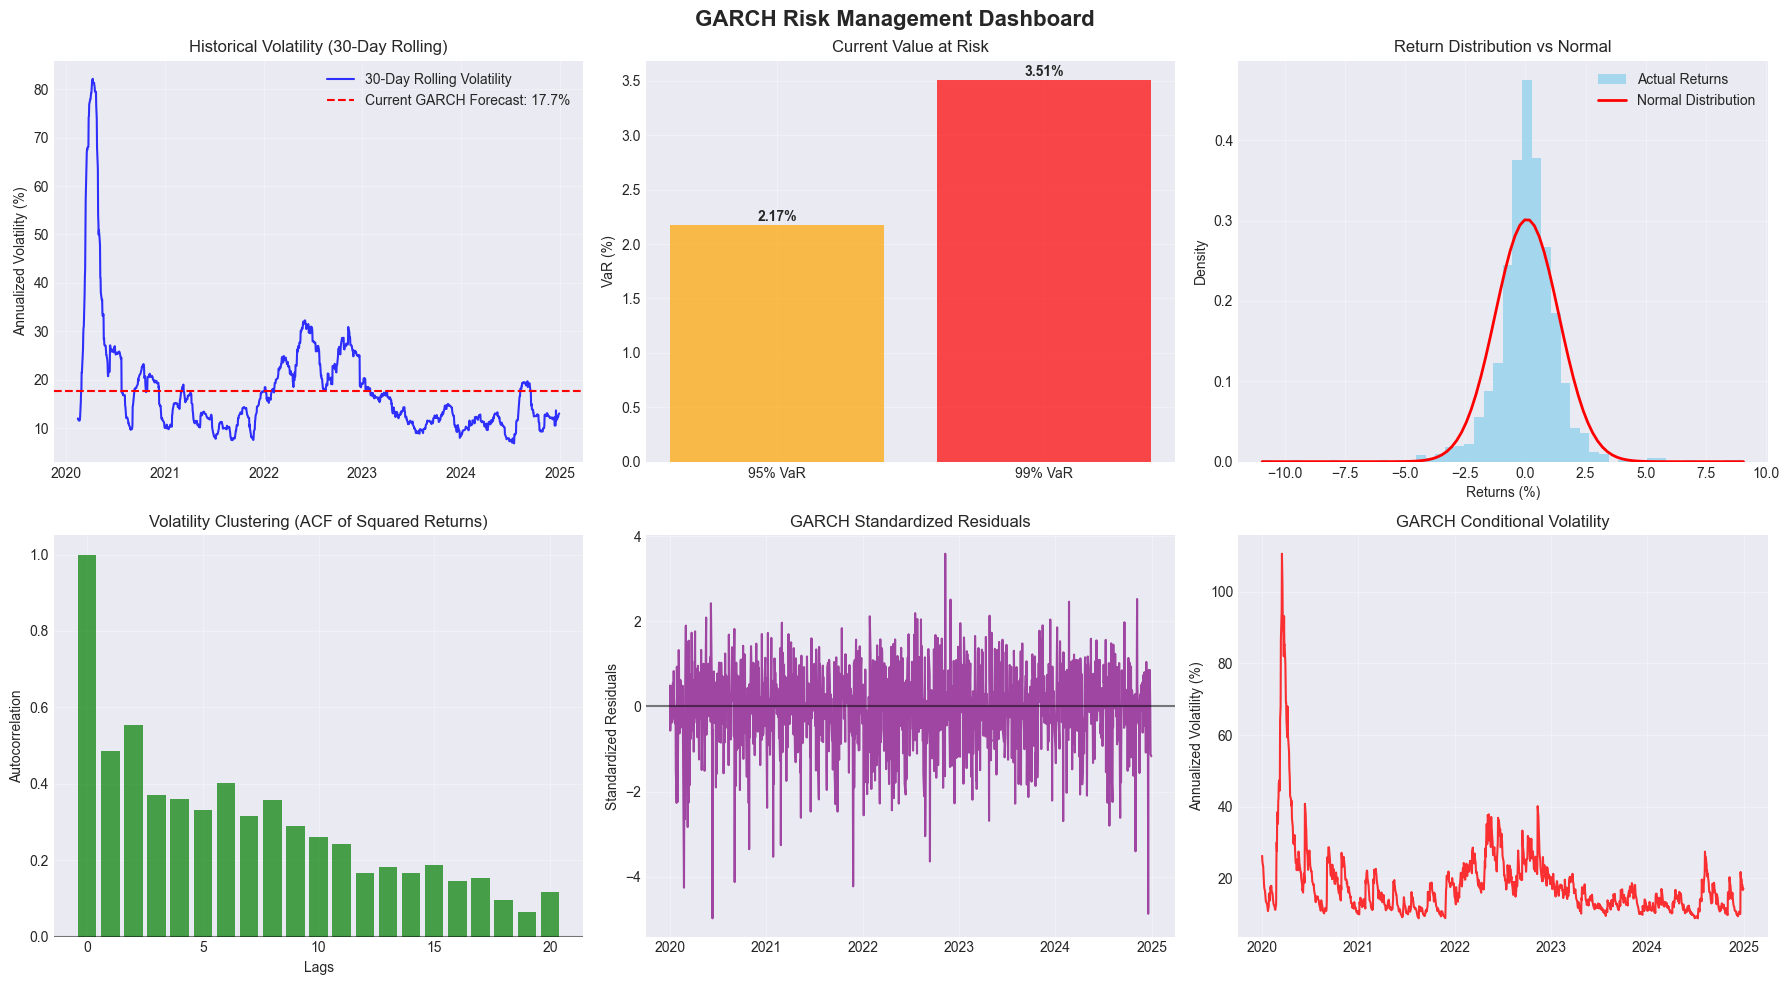


RISK DASHBOARD SUMMARY
Current Volatility Forecast: 17.73%
30-Day Realized Volatility: 13.04%
1-Year Realized Volatility: 12.57%

95% VaR (1-day): 2.17%
99% VaR (1-day): 3.51%

Risk Assessment:
🟡 MODERATE RISK: Current volatility elevated


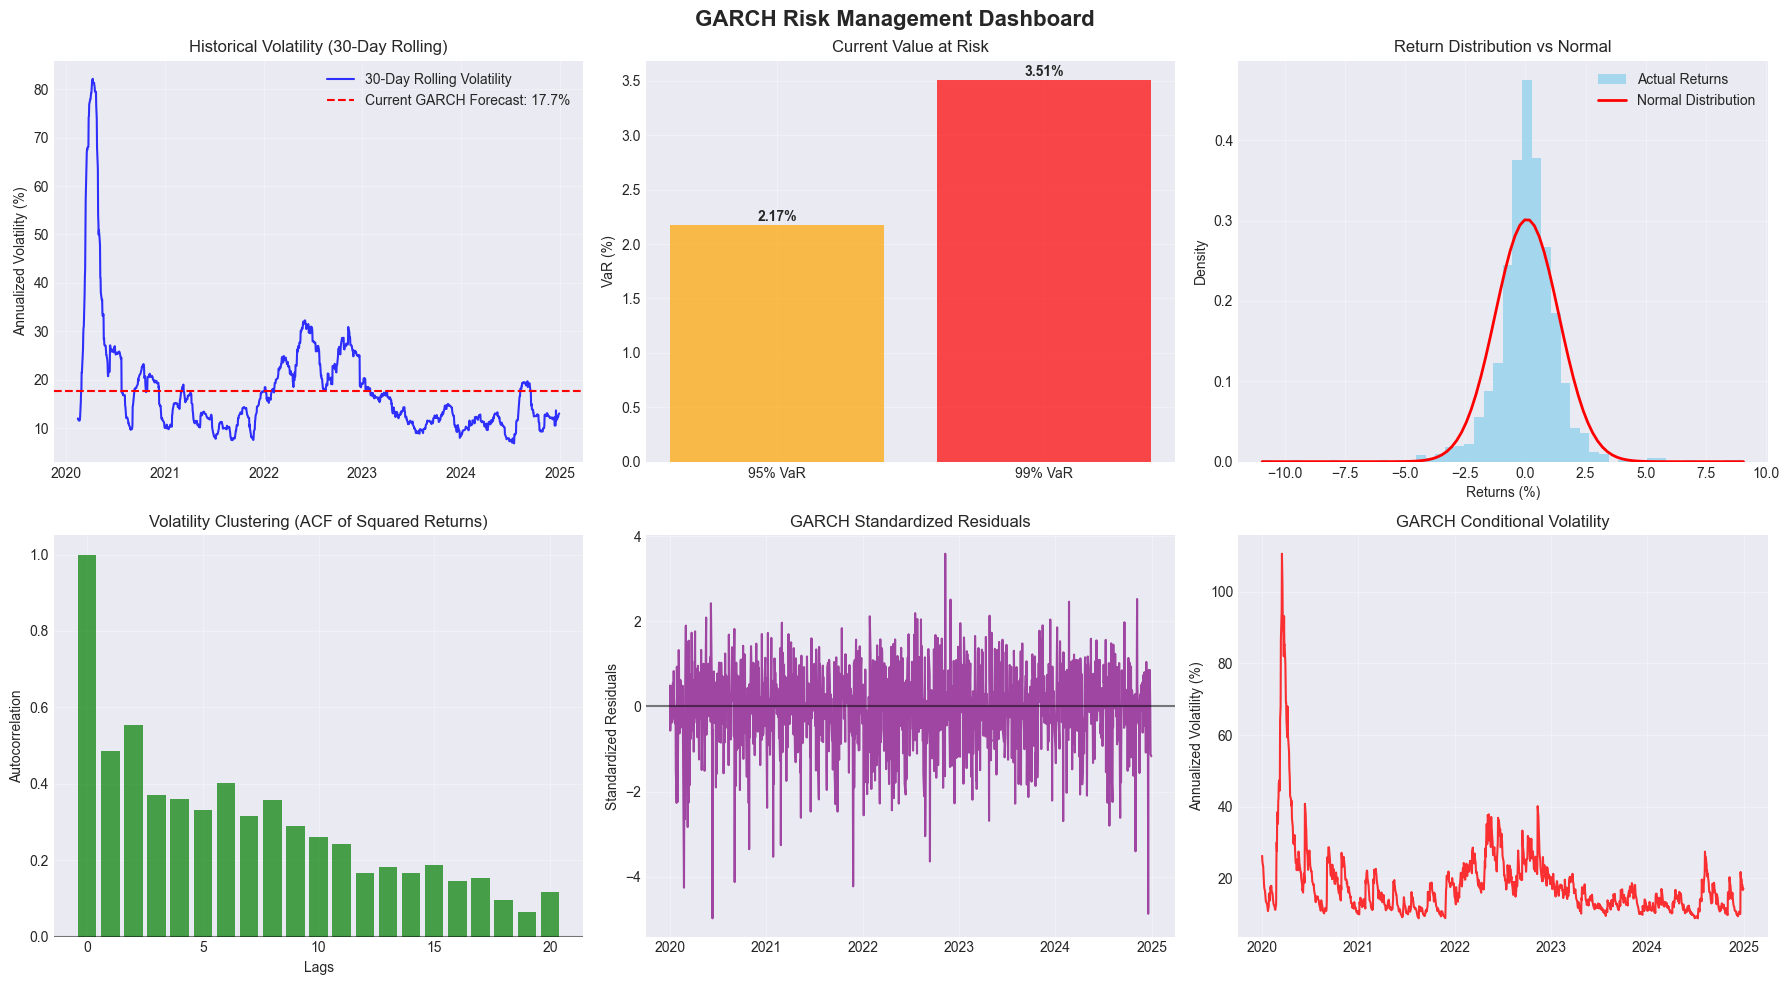

In [48]:
create_simple_risk_dashboard(best_model, returns_df['SPY'], title="GARCH Risk Management Dashboard")

In [49]:
create_portfolio_risk_summary(returns_df, portfolio_weights=None, asset_names=asset_names)


PORTFOLIO RISK SUMMARY
Individual Asset Volatilities:
  SPY: 21.00% (Weight: 25.0%)
  TLT: 17.97% (Weight: 25.0%)
  GLD: 15.53% (Weight: 25.0%)
  VXX: 75.92% (Weight: 25.0%)

Portfolio Volatility: 17.27%

Correlation Matrix:
       SPY    TLT    GLD    VXX
SPY  1.000 -0.150  0.158 -0.710
TLT -0.150  1.000  0.267  0.129
GLD  0.158  0.267  1.000 -0.095
VXX -0.710  0.129 -0.095  1.000

Diversification Analysis:
  Weighted Average Volatility: 32.60%
  Portfolio Volatility: 17.27%
  Diversification Benefit: 15.33%


{'portfolio_vol': 17.270001792850035,
 'individual_vols': SPY    21.000075
 TLT    17.969708
 GLD    15.525967
 VXX    75.923741
 dtype: float64,
 'diversification_benefit': 15.33487094512623,
 'correlation_matrix':           SPY       TLT       GLD       VXX
 SPY  1.000000 -0.149611  0.158440 -0.710000
 TLT -0.149611  1.000000  0.266832  0.129034
 GLD  0.158440  0.266832  1.000000 -0.095294
 VXX -0.710000  0.129034 -0.095294  1.000000}